------
# Face recognition
------
## Requeriments of face regnition systems

- Speed
- Scalability
- High accuracy with small data
- One-shot learning

------

## Naive one-shot prediction - Euclidean distance between two vectors

Given the true image and a test image, one naive approach for a one-shot prediction is to simply measure the difference between the two images. All images are simply three dimensional vectors. We know that the Euclidean distance provides a mathematical formulation of the difference between two vectors. 

![example euclidan](https://i.imgur.com/BEzBqWs.png)


Although the Euclidean distance for facial recognition makes sense on paper, it has a poor practical value. In reality, photos can be different due to variations in angles and lighting, and also changes in the appearance of the subject, which can arise due to the wearing of accessories such as glasses. As you can imagine, a facial recognition system that uses the Euclidean distance alone would perform terribly in reality.

-----

## Siamese neural networks

Intuitively, humans recognize faces by comparing their key features. For example, humans use features such as the shape of eyes, the thickness of the eyebrows, the sizse of the nose, the overall shape of the face, and so on to recognize a person. This ability comes naturally to us, and we are seldom affected by varations in angles and lighting. For facial recognition, researchers have found that when convolutional layers are applied to human faces, they extract spatial features, such as eyes and noses. 

This insight forms the core of our algorithm for one-shot learning:

- Use convolutional layers to extract identifying features from faces. 
- Using the euclidan distance, measure the difference of the two lower-dimension vectors output from the convolutional layers. The Euclidian distance is *inversely (?)* proportional to the simalirity between the two images

Ona las thing to note is that, since we are feeding two images into our neural network simultaneously, we need to separete sets of convolutional layers. However, we require the two separete sets of convolutional layers to shape the same weights, because we wanto similar faces to be mapped to the same point in the lower-dimension feature space. 

We can thus think of these two sets of convolutional layers as twins, as they share the same weights. 

![twins](https://i.imgur.com/Px8pWP9.png)

This neural network is known as a Siamese neural network, because just like a Siamese twin, it has a conjoined component at the convolutional layers.

-----

## Contrasstive loss

This new paradigm of training a nerual network for distance-based predictions instead of classification-based preditions requires a new loss fuction. 

We require a new distance-based loss function to train our Siamese neural network for facial recognition. The distance based loss function that we will be using is called the contrastove loss function.

Take a look at the following variables:

- **$ Y_{true} $** Let $ Y_{true} $ be 1 if the two input images are from the same subject (same face), and 0 if the two input images are from different subjects.
- **$ D $** The predicted distance output from the neural network

So, the contrastive loss is defined as follows:

$$
\textrm{Contrastive Loss} = Y_{true} \ast D^2 + ( 1-Y_{true}) \ast \textrm{max} ( \textrm{margin} - D, 0)
$$

The following graph  shows the loss for the increasing predicted distance, when the faces are similar (left) and when the faces are different (right)

![graph](https://i.imgur.com/N0pZbXQ.png)

Simply put, the constrastive loss function ensures that our siamese neural network learns to predict a small distance when the faces in the true and test images are the same, and a large distance when the faces is the true and test images are differnt.

------

# The faces dataset

The dataset that we have chosen is the Database of Faces, created by AT&T Laboratories, Cambridge.  The database contains photos of 40 subjects, with 10 photos for each subject. The photos of each subject were taken under different lighting and angles, and they have different facial expressions. For certain subjects, multiple photos were taken of people with and without glasses


The images are stored in subfolders, with one subfolder per subject. Let's import the raw-image files as NumPy arrays in Python. We start by declaring a variable with the file path

In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

CURRENT_DIR = Path('.').resolve()
MODULES_DIR = CURRENT_DIR.parent.joinpath('src')
sys.path.append(str(MODULES_DIR))
DATA_DIR = CURRENT_DIR.parent.joinpath('Data')

In [3]:
face_dir = DATA_DIR.joinpath('att_faces')

Next, we want to iterate through each subfolder in the directory, and load each image in the subfolder as NumPy array. To dothat, we can import and use the `load_img` and `img_to_array` functions provided in `keras.preprocessing.image`

In [22]:
from tensorflow.keras.utils import img_to_array, load_img
import numpy as np

In [5]:
X_train, Y_train = [], []
X_test, Y_test = [], []
directories = sorted([f for f in face_dir.iterdir() if f.is_dir()])

Iterate through the list of subfolders (subjects)

In [15]:
for idx, folder in enumerate(directories):
    files = sorted(face_dir.joinpath(folder.name).glob('*.pgm'))
    for file in files:
        img = load_img(file, color_mode='grayscale')
        img = img_to_array(img).astype('float32')/255
        if idx < 35:
            X_train.append(img)
            Y_train.append(idx)
        else:
            X_test.append(img)
            Y_test.append(idx)

Finally, we convert X_train, Y_train, X_test and X_test into Numpy arrays

In [23]:
X_test = np.array(X_test)
X_train = np.array(X_train)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)

We now have our training and testing dataset. We'll train our Siamese Nerual network using the training set and test it using the phots in the testing dataset. 

------

Let's plot out some images from a subject to better understand the kind of data we are working with. The following code plot nine of the images from a particular subject

In [24]:
import matplotlib.pyplot as plt

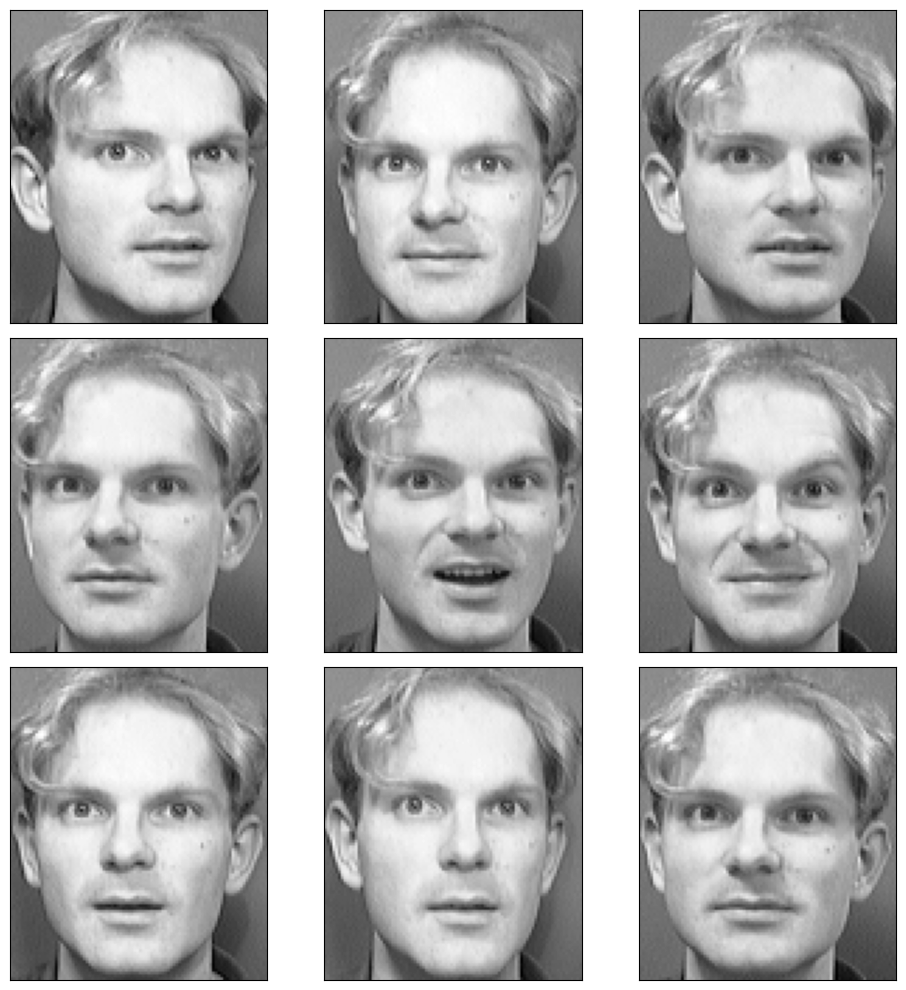

In [26]:
subject_idx = 9
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(10,10))
subject_img_idx = np.where(Y_train==subject_idx)[0].tolist()

for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    img = X_train[subject_img_idx[i]]
    img = np.squeeze(img)
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

-----

We also plot a sinlge image from the first nine subjects, using the following code:

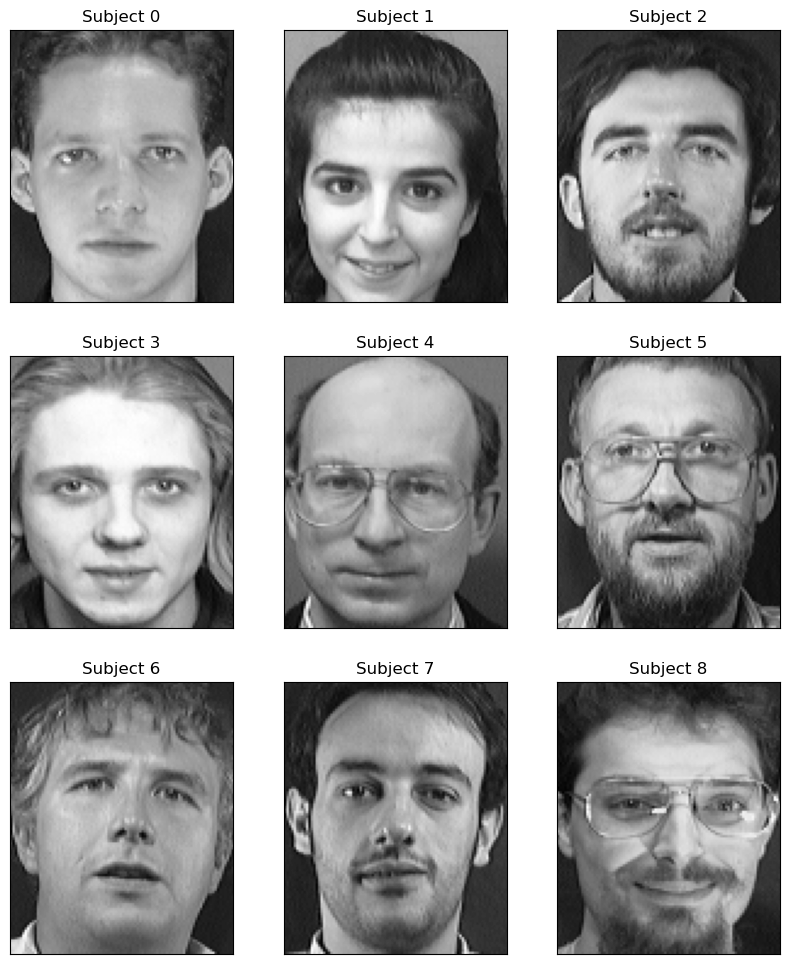

<Figure size 640x480 with 0 Axes>

In [27]:
subjects = range(10)
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(
    3,3,figsize=(10,12))
subject_img_idx = [np.where(Y_train==i)[0].tolist()[0] for i in subjects]
for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    img = X_train[subject_img_idx[i]]
    img = np.squeeze(img)
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Subject {}".format(i))
plt.show()
plt.tight_layout()